# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 28.02.2024

Мягкий дедлайн: 19.03.2024 23:59 MSK

Жёсткий дедлайн: 25.03.2024 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/60281

Username — ваша фамилия и имя на латинице именно в таком порядке



ник в контесте 

mmzabelin@edu.hse.ru


посылки

https://contest.yandex.ru/contest/60281/run-report/110827969/


https://contest.yandex.ru/contest/60281/run-report/110829933/

# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 16](https://github.com/esokolov/ml-course-hse/blob/master/2022-spring/seminars/sem16-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [1]:
import numpy as np
seed = 0xDEADF00D
np.random.seed(seed)

In [2]:
L = np.load('L.npy')
n, m = L.shape

**Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои. 

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

In [3]:
import numpy as np
from scipy.special import expit, logsumexp

def softplus(x):
    '''More stable version of log(1 + exp(x))'''
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)


In [4]:
def posterior(alpha, beta, L):
    AB = beta.reshape((n, 1)) * alpha.reshape((1, m))
    log_prob_1 = np.sum(-L * softplus(-AB) - (1 - L) * softplus(AB), axis=1) + np.log(0.5)
    log_prob_0 = np.sum(-(1 - L) * softplus(-AB) - L * softplus(AB), axis=1) + np.log(0.5)
    return np.array([np.exp(log_prob_1) / (np.exp(log_prob_0) + np.exp(log_prob_1)), np.exp(log_prob_0) / (np.exp(log_prob_1) + np.exp(log_prob_0))])

def log_likelihood(alpha, beta, L, z):
    Z = np.tile(z.reshape((n, 1)), m)
    AB = beta.reshape((n, 1)) * alpha.reshape((1, m))
    return np.sum(np.sum(-(L == Z) * softplus(-AB) - (L != Z) * softplus(AB), axis=1) + np.log(0.5))

def alpha_grad_lb(alpha, beta, L, q):
    AB = beta.reshape((n, 1)) * alpha.reshape((1, m))
    Q0 = np.tile(q[0].reshape((n, 1)), m)
    Q1 = np.tile(q[1].reshape((n, 1)), m)
    B = np.tile(beta.reshape((n, 1)), m)
    return np.sum(Q0 * B * ((1 - L) * expit(-AB) - L * expit(AB)) + Q1 * B * (L * expit(-AB) - (1 - L) * expit(AB)), axis=0)

def logbeta_grad_lb(alpha, beta, L, q):
    n, m = L.shape
    AB = beta.reshape((n, 1)) @ alpha.reshape((1, m))
    Q0 = q[0].reshape((n, 1))
    Q1 = q[1].reshape((n, 1))
    A = alpha.reshape((1, m))

    grad = np.sum((Q0 + Q1) * A * ((1 - L) * expit(-AB) - L * expit(AB)), axis=1)
    
    return grad



In [5]:
def em(L, n_steps=1000, lr=1e-3):
    n, m = L.shape  
    alpha = np.random.randn(m)
    logbeta = np.random.randn(n)
    q = np.ones((2, n)) * 0.5

    for step in range(n_steps):
        # E-step
        q = posterior(alpha, np.exp(logbeta), L)
        # M-step
        alpha += lr * alpha_grad_lb(alpha, np.exp(logbeta), L, q)
        logbeta += lr * logbeta_grad_lb(alpha, np.exp(logbeta), L, q) * np.exp(logbeta)


    return alpha, np.exp(logbeta), q



In [6]:
alpha, beta, q = em(L)

**Задание 2. (1 балл)** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$). 

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
y_true = np.load('y.npy')
print('---')

y_pred_em_types = (L - np.ones(L.shape) * 0.5) @ np.sign(alpha) < 0
print(f'1) Expert types EM accuracy: {accuracy_score(y_true, y_pred_em_types)}')

y_pred_em_prob = q[0] > 0.5
print(f'2) Latent EM accuracy: {accuracy_score(y_true, y_pred_em_prob)}')

y_pred_votes = 2 * np.sum(L, axis=1) >= m
print(f'3) Expert votes accuracy: {accuracy_score(y_true, y_pred_votes)}')


---
1) Expert types EM accuracy: 0.9525
2) Latent EM accuracy: 0.9555
3) Expert votes accuracy: 0.892


**Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$. Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли врено размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

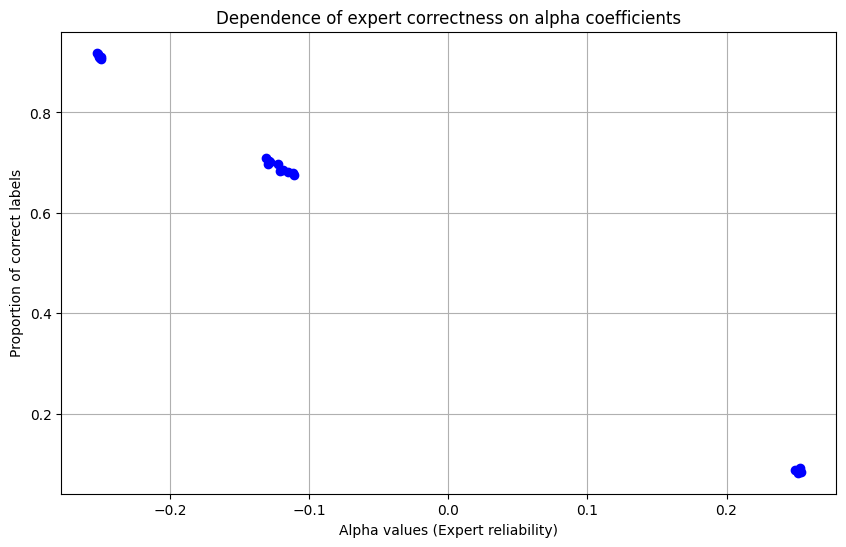

In [11]:
import matplotlib.pyplot as plt

correctness = np.mean(L == y_true[:, None], axis=0)

plt.figure(figsize=(10, 6))
plt.scatter(alpha, correctness, c='blue')
plt.xlabel('Alpha values (Expert reliability)')
plt.ylabel('Proportion of correct labels')
plt.title('Dependence of expert correctness on alpha coefficients')
plt.grid(True)
plt.show()


Из представленного графика видно, что существует явная зависимость между коэффициентами $\alpha$ экспертов и долей правильно размеченных ими объектов. Мы можем наблюдать следующие тенденции:

Эксперты с положительным значением $\alpha$ имеют высокую долю правильных ответов, что указывает на их надежность и компетентность. Чем выше значение $\alpha$, тем выше вероятность того, что эксперт правильно разметил объекты.
На другом конце спектра мы видим экспертов с очень низкими (отрицательными) значениями $\alpha$. Эти эксперты имеют низкую долю правильных ответов, что может указывать на то, что они систематически голосуют неверно — либо из-за непонимания задачи, либо намеренно.
Интересно, что нет экспертов с $\alpha$, приближающимися к нулю, что было бы указанием на то, что их метки не лучше случайного угадывания. Все эксперты имеют выраженные положительные или отрицательные значения $\alpha$, что делает их метки значимыми, хотя и возможно неправильными для отрицательных $\alpha$.
Тот факт, что некоторые эксперты имеют отрицательные значения $\alpha$ и при этом низкую долю правильных меток, подтверждает гипотезу о том, что они могут намеренно или систематически голосовать неправильно. В таких случаях можно рассмотреть возможность исключения их меток из анализа или предпринять дополнительные шаги для проверки их компетентности.

**Задание 4. (бонус, 2 балла)**  Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

In [12]:
def modified_em(L, gold_indices, gold_labels, n_steps=1000, lr=1e-3):
    n, m = L.shape 
    alpha = np.random.randn(m)
    logbeta = np.random.randn(n)
    q = np.ones((2, n)) * 0.5  

    for step in range(n_steps):
        # E-step 
        q = posterior(alpha, np.exp(logbeta), L) 
        for idx, label in zip(gold_indices, gold_labels):  
            q[:, idx] = 0  
            q[label, idx] = 1  

        # M-step
        alpha += lr * alpha_grad_lb(alpha, np.exp(logbeta), L, q)
        logbeta += lr * logbeta_grad_lb(alpha, np.exp(logbeta), L, q) * np.exp(logbeta)


    return alpha, np.exp(logbeta), q


In [13]:
majority_vote = np.mean(L, axis=1) > 0.5

gold_indices = np.where(majority_vote == y_true)[0]
gold_labels = y_true[gold_indices]

gold_indices, gold_labels


(array([   0,    1,    2, ..., 1996, 1998, 1999]),
 array([1, 1, 1, ..., 1, 0, 0]))

In [14]:
alpha, beta, q = modified_em(L, gold_indices, gold_labels, n_steps=1000, lr=1e-3)


In [15]:
non_gold_indices = np.setdiff1d(np.arange(len(y_true)), gold_indices)

y_pred_em_types = (L - np.ones(L.shape) * 0.5) @ np.sign(alpha) < 0
accuracy_em_types = accuracy_score(y_true[non_gold_indices], y_pred_em_types[non_gold_indices])
print(f'1) Expert types EM accuracy (excluding gold questions): {accuracy_em_types}')

y_pred_em_prob = q[0] > 0.5
accuracy_em_prob = accuracy_score(y_true[non_gold_indices], y_pred_em_prob[non_gold_indices])
print(f'2) Latent EM accuracy (excluding gold questions): {accuracy_em_prob}')

y_pred_votes = 2 * np.sum(L, axis=1) >= m
accuracy_votes = accuracy_score(y_true[non_gold_indices], y_pred_votes[non_gold_indices])
print(f'3) Expert votes accuracy (excluding gold questions): {accuracy_votes}')


1) Expert types EM accuracy (excluding gold questions): 0.3541666666666667
2) Latent EM accuracy (excluding gold questions): 0.7083333333333334
3) Expert votes accuracy (excluding gold questions): 0.265625


# Выравнивание слов (Word Alignment)

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно). 

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

**Задание -2. (0.5 балла)** Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

In [32]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
all_sentences_combined = []
all_alignments_combined = []

root_dir = '/Users/maximzabelin/My/edc/ml_hw/hw_9/CzEnAli_1.0/merged_data'


for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        file_path = os.path.join(subdir, file)
        try:
            all_sentences, all_targets = extract_sentences(file_path)
            all_sentences_combined.extend(all_sentences)
            all_alignments_combined.extend(all_targets)
            print(f"{file} - OK")
            print('-----')
        except Exception as e:
            print(f"Error processing {file}: {e}")
            print('-----')

Error processing .DS_Store: 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
-----
project_syndicate_bacchetta1.wa - OK
-----
project_syndicate_blanchard8.wa - OK
-----
project_syndicate_balibar1.wa - OK
-----
project_syndicate_bertram19.wa - OK
-----
project_syndicate_blo3.wa - OK
-----
project_syndicate_bck2.wa - OK
-----
project_syndicate_ban1.wa - OK
-----
project_syndicate_balcerowicz1.wa - OK
-----
project_syndicate_ber17.wa - OK
-----
project_syndicate_balkenende1.wa - OK
-----
wsj_2435.wa - OK
-----
wsj_2399.wa - OK
-----
wsj_2211.wa - OK
-----
wsj_2201.wa - OK
-----
wsj_2393.wa - OK
-----
wsj_2214.wa - OK
-----
wsj_2315.wa - OK
-----
wsj_2332.wa - OK
-----
wsj_2246.wa - OK
-----
wsj_2203.wa - OK
-----
wsj_2212.wa - OK
-----
wsj_2303.wa - OK
-----
wsj_2313.wa - OK
-----
wsj_2202.wa - OK
-----
wsj_2222.wa - OK
-----
wsj_2338.wa - OK
-----
wsj_2308.wa - OK
-----
wsj_2248.wa - OK
-----
wsj_2309.wa - OK
-----
wsj_2249.wa - OK
-----
wsj_2406.wa - OK
-----
ws

**Задание -1. (0.5 балла)** Реализуйте функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, постройте словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. Реализации функций также отправьте в Яндекс.Контест.

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from preprocessing import get_token_to_index, tokenize_sents

t_idx_src, t_idx_tgt = get_token_to_index(all_sentences_combined)
tokenized_sentences = tokenize_sents(all_sentences_combined, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности. 

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [37]:
from models import DiceAligner

baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

**Задание 0. (0.5 балла)** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from metrics import compute_aer

compute_aer(all_targets,baseline.align(tokenized_sentences))

0.9643829876388016

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$ 

**Задание 1. (2 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

(∩｀-´)⊃━☆ﾟ.*･｡
Процесс EM-алгоритма для данной модели состоит из следующих шагов:

**E-шаг:**

На этом шаге, мы обновляем наши оценки для распределений латентных переменных $A$, используя текущие параметры модели $\Theta$. Распределение $q(A)$ определяется для каждого $a_i$ отдельно как:

$$
q_i(a_i) \propto p(a_i) p(t_i | S, \Theta, a_i) = \theta(t_i|s_{a_i})
$$

Где $\propto$ означает пропорциональность, и мы нормализуем распределение так, чтобы оно суммировалось в единицу:

$$
q_i(a_i) = \frac{\theta(t_i|s_{a_i})}{\sum_{j=1}^n \theta(t_i|s_j)}
$$

**M-шаг:**

На этом шаге мы оптимизируем параметры модели $\Theta$, максимизируя ожидаемое логарифмическое правдоподобие выборки, которое теперь включает в себя оценки распределений латентных переменных. Для одного предложения:

$$
\mathbb{E}_{A \sim q(A)}[\log p(T|S, \Theta, A)] = \sum_{i=1}^m \sum_{j=1}^n q_i(j) \log \theta(t_i|s_j) \rightarrow \max_{\Theta}
$$

Мы максимизируем это выражение относительно $\Theta$, при условии, что сумма вероятностей перевода для каждого слова равна единице.

**Определение нижней границы правдоподобия (Lower Bound $\mathcal{L}$):**

Нижняя граница правдоподобия для всего корпуса определяется как сумма нижних границ по всем предложениям:

$$
\mathcal{L}(\Theta, q) = \sum_{\text{предложение}} \mathcal{L}_{\text{предложение}}(q_{\text{предложение}}, \Theta)
$$

где $\mathcal{L}_{\text{предложение}}(q_{\text{предложение}}, \Theta)$ вычисляется как:

$$
\mathcal{L}_{\text{предложение}} = \sum_{i=1}^m \sum_{j=1}^n q_i(j) \log \frac{\theta(t_i|s_j)}{n \cdot q_i(j)}
$$

**Оптимизация параметров $\Theta$:**

Максимизация нижней границы правдоподобия в отношении $\Theta$ требует, чтобы мы нашли аналитическое решение для $\theta(t|s)$, используя условие Каруша-Куна-Таккера:

$$
\sum_{\text{предложение}} \left[ (t, s) \in (T, S) \right] \frac{q_i(j)}{\theta(t_i|s_j)} - \lambda_s = 0
$$

Отсюда мы получаем, что:

$$
\theta(t|s) = \frac{\sum_{\text{предложение}} q_i(j)}{\lambda_s}
$$

И, используя условие нормировки, находим $\lambda_s$:

$$
\lambda_s = \sum_t \sum_{\text{предложение}} \theta(t|s) \cdot \left[ (t, s) \in (T, S) \right]
$$

Вроде как все получилось.


**Задание 2. (2.5 балла)** Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from models import WordAligner

word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
history = word_aligner.fit(tokenized_sentences)

predicted_alignments = word_aligner.align(tokenized_sentences)

predicted_for_aer = [list(map(lambda x: (x[0]-1, x[1]-1), alignment)) for alignment in predicted_alignments]

aer = compute_aer(all_targets, predicted_for_aer)

print(f"Alignment Error Rate (AER): {aer}")

Alignment Error Rate (AER): 0.9893095768374165


Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [43]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [44]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

['a', '.', ',']

In [45]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['a', '.', ',']

In [46]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['a', '.', ',']

In [47]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['byl', 'od', ',']

In [48]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['a', ',', '.']

**Задание 3. (0.5 балла)** Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

In [ ]:
# (>ω<)ノ—==ΞΞ☆*✲ﾟ

In [50]:
def inv(arr):
    return [(x[1], x[0]) for x in arr]

In [54]:
from preprocessing import TokenizedSentencePair, LabeledAlignment

translation_probabilities = word_aligner.translation_probs
target_to_source_probs = (translation_probabilities / np.sum(translation_probabilities, axis=0, keepdims=True)).T

reversed_sentences = [TokenizedSentencePair(pair.target_tokens, pair.source_tokens) for pair in tokenized_sentences]
inverted_alignments = [LabeledAlignment([(y, x) for x, y in alignment.sure], [(y, x) for x, y in alignment.possible]) for alignment in all_targets]

alignments_predictions = []
for pair in reversed_sentences:
    source_token_indices = pair.source_tokens
    target_token_indices = pair.target_tokens
    selected_source_indices = np.argmax(target_to_source_probs[np.ix_(source_token_indices, target_token_indices)], axis=0)
    alignments_predictions.append([(source_index + 1, target_index + 1) for source_index, target_index in zip(selected_source_indices, range(len(target_token_indices)))])

aer = compute_aer(inverted_alignments, alignments_predictions)

print(f"AER: {aer}")

AER: 0.9728285077951002


**Задание 4. (0.5 балла)** Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

In [ ]:
# (•̀ 3 •́)━★☆.*･｡ﾟ

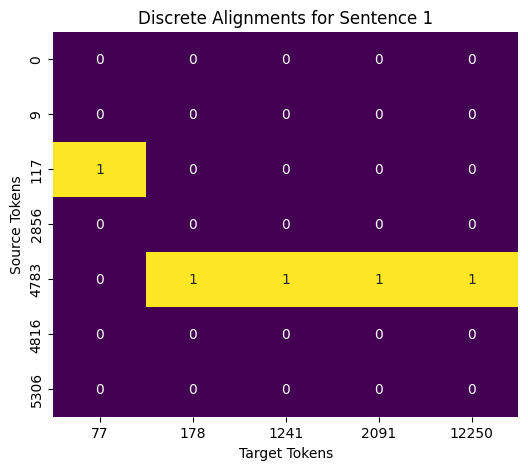

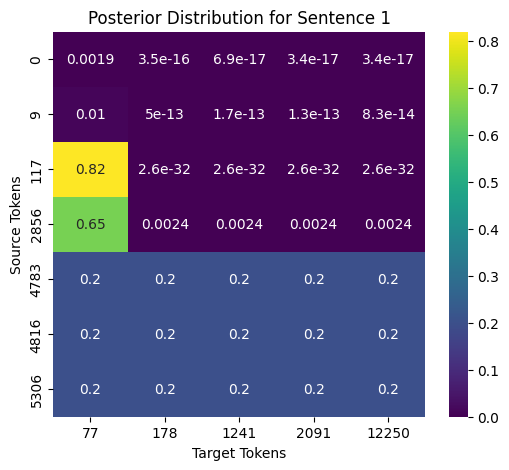

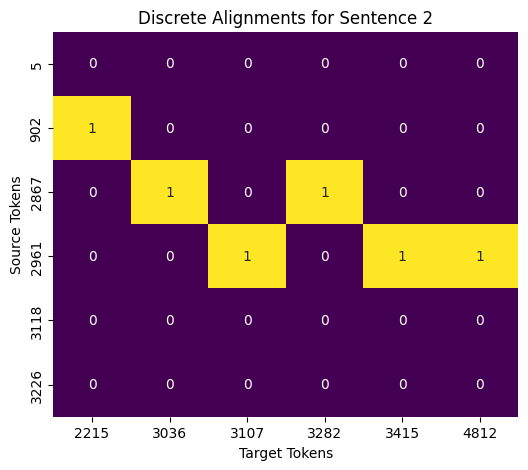

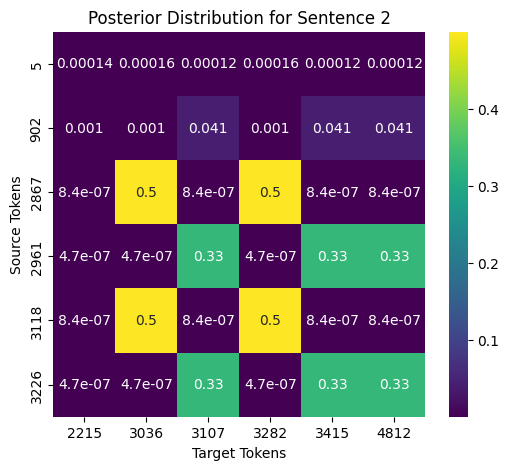

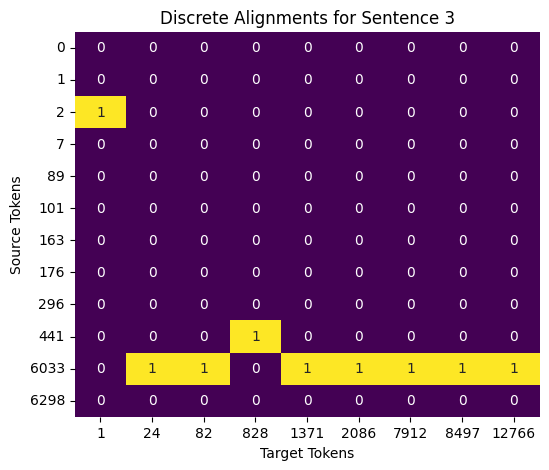

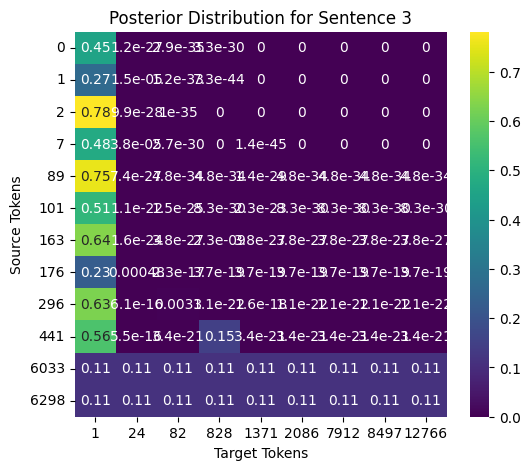

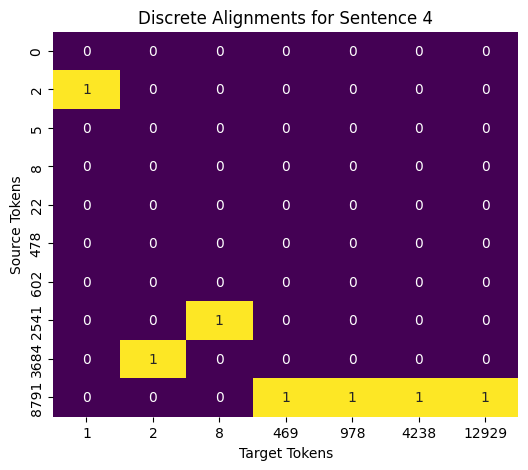

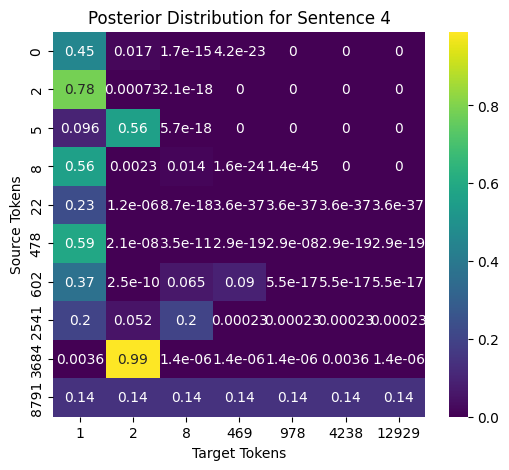

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_alignments_and_posteriors(tokenized_sentences, translation_probs, num_sentences=4):
    for i, sentence in enumerate(tokenized_sentences[:num_sentences]):
        source_indices = np.unique(sentence.source_tokens)
        target_indices = np.unique(sentence.target_tokens)

        discrete_alignments = np.zeros((len(source_indices), len(target_indices)))
        posterior_distribution = translation_probs[np.ix_(source_indices, target_indices)]
        
        best_alignments = np.argmax(posterior_distribution, axis=0)
        discrete_alignments[best_alignments, np.arange(len(target_indices))] = 1

        plt.figure(figsize=(6, 5))
        sns.heatmap(discrete_alignments, cmap="viridis", annot=True, cbar=False,
                    xticklabels=[str(t) for t in target_indices], yticklabels=[str(s) for s in source_indices])
        plt.title(f"Discrete Alignments for Sentence {i+1}")
        plt.xlabel("Target Tokens")
        plt.ylabel("Source Tokens")
        plt.show()

        plt.figure(figsize=(6, 5))
        sns.heatmap(posterior_distribution, cmap="viridis", annot=True,
                    xticklabels=[str(t) for t in target_indices], yticklabels=[str(s) for s in source_indices])
        plt.title(f"Posterior Distribution for Sentence {i+1}")
        plt.xlabel("Target Tokens")
        plt.ylabel("Source Tokens")
        plt.show()

visualize_alignments_and_posteriors(tokenized_sentences, P)


В целом видим, что модель неплохо мправаляется в тех местах, где большие значеничя и соответственно хуже,где много ячеек с не очень большими значениями

Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$

**Задание 5. (1.5 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия.

ଘ(๑˃̵ᴗ˂̵)━☆ﾟ.*･｡ﾟ


#### E-шаг:

На E-шаге EM-алгоритма, аналогично предыдущему варианту модели, но с учетом нового предположения, апостериорное распределение $q_i(a_i=k)$ вычисляется как:

$$
q_i(a_i=k) = \frac{\phi_{n, m}(k|i) \theta(t_i|S_k)}{\sum_{z=1}^n \phi_{n, m}(z|i) \theta(t_i|S_z)}
$$

где $\phi_{n, m}(k|i)$ — вероятность того, что слово $i$ в целевом предложении соответствует слову $k$ в исходном предложении при заданных длинах предложений $m$ и $n$.

#### M-шаг:

На M-шаге максимизируется математическое ожидание логарифма условной вероятности по апостериорному распределению, полученному на E-шаге. Для одного предложения:

$$
\mathbb{E}_{A \sim q(a)}(\log p(T|S, \Theta, A)) = \sum_{i=1}^m \sum_{k=1}^n q_i(k) \log \frac{\phi_{n, m}(k|i) \theta(t_i|S_k)}{q_i(k)}
$$

Данное выражение разделяется на два независимых терма, которые максимизируются отдельно по параметрам $\Theta$ и $\phi$. Второй терм максимизируется аналогично предыдущей задаче, а для первого терма составляется функция Лагранжа с ограничениями на $\phi$. Решая уравнения Лагранжа, получаем:

$$
\phi_{n, m}(k|i) = \frac{\sum_{\text{sent}} q_i(k)}{\text{num}(n, m)}
$$

где $\text{num}(n, m)$ — количество предложений с длинами $n$ и $m$, а суммирование ведется по всем таким предложениям.

#### Нижняя оценка правдоподобия:

Нижняя оценка правдоподобия (ELBO) определяется как:

$$
L = \sum_{\text{sent}} \sum_{i=1}^m \sum_{k=1}^n q_i(k) \log \frac{\phi_{n, m}(k|i) \theta(t_i|S_k)}{q_i(k)}
$$

Эта оценка используется для проверки сходимости EM-алгоритма и оценки качества найденных параметров модели.


**Задание 6. (2 балла)** Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
from models import WordPositionAligner
# (≧ ◡ ≦)━★☆.*･｡ﾟ

position_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 20)

position_aligner.translation_probs = np.copy(word_aligner.translation_probs)

history = position_aligner.fit(tokenized_sentences)

predicted_alignments = position_aligner.align(tokenized_sentences)

predicted_for_aer = [list(map(lambda x: (x[0]-1, x[1]-1), alignment)) for alignment in predicted_alignments]

aer = compute_aer(all_targets, predicted_for_aer)

print(f"AER: {aer}")

AER: 0.9716765646413887


**Задание 7. (1 балл)** В предыдущих пунктах мы никак не заостряли внимание на предобработке текстов, что может негативно влиять на результаты обученной модели. Например, сейчас метод выравнивания учитывает регистр, а слова на чешском языке вдобавок обладают богатой морфологией и большим количеством диакритических знаков. Если сократить количество параметров модели (различных слов), можно ускорить обучение и добиться лучших результатов, потому что статистики по словам будут считаться по большему числу параллельных предложений.

Примените к исходным данным [Unicode-нормализацию](https://en.wikipedia.org/wiki/Unicode_equivalence#Normalization), приведите их к нижнему регистру и обучите модель выравнивания заново. Сравните качество и скорость обучения с предыдущими результатами и сделайте выводы. Если вы найдете в данных ещё какие-то проблемы, которые можно исправить более грамотной предобработкой, также продемонстрируйте, как их решение влияет на качество.

**Важно:** здесь и далее в процессе обработки данных у вас может получаться, что из тестовых данных будут удалены предложения из-за отсутствия слов в словаре. Если такое всё же произошло, для корректности сравнения считайте AER вашей модели на удалённых предложениях равным 1.

In [98]:
import unicodedata
from preprocessing import get_token_to_index, tokenize_sents, SentencePair

def preprocess_text(text):
    return unicodedata.normalize('NFD', text).lower()



all_sentences_preprocessed = [
    SentencePair(
        source=[preprocess_text(token) for token in pair.source],
        target=[preprocess_text(token) for token in pair.target]
    )
    for pair in all_sentences_combined
]

t_idx_src_preprocessed, t_idx_tgt_preprocessed = get_token_to_index(all_sentences_preprocessed)

tokenized_sentences_preprocessed = tokenize_sents(all_sentences_preprocessed, t_idx_src_preprocessed, t_idx_tgt_preprocessed)

position_aligner = WordPositionAligner(len(t_idx_src_preprocessed), len(t_idx_tgt_preprocessed), 20)
history_preprocessed = position_aligner.fit(tokenized_sentences_preprocessed)

predicted_alignments_preprocessed = position_aligner.align(tokenized_sentences_preprocessed)

predicted_for_aer_preprocessed = [list(map(lambda x: (x[0]-1, x[1]-1), alignment)) for alignment in predicted_alignments_preprocessed]

aer_preprocessed = compute_aer(all_targets, predicted_for_aer_preprocessed)
print(f"AER with preprocessed data: {aer_preprocessed}")


AER with preprocessed data: 0.9661946094106898


**Задание 7. (бонус, до 3 баллов)** 

Улучшите качество получившейся системы настолько, насколько сможете. За каждые 5 процентов, на которые AER на тех же данных получается меньше, чем минимум ошибки всех предыдущих моделей, вы получите по 1 бонусному баллу.

Ниже приведены несколько идей, которые могут помочь вам повысить 

* Модифицировать модель: как вы можете понять, недостатком второго реализованного вами подхода является избыточное число параметров из-за необходимости подерживать отдельную матрицу для каждой различной пары длин предложений в корпусе. В статье https://www.aclweb.org/anthology/N13-1073.pdf приведён способ снижения числа параметров, задающих априорное распределение позиций выравнивания, который позволяет в десять раз быстрее обучать модель и получать лучшее качество.
* Агрегация по двум направлениям: в статье https://www.aclweb.org/anthology/J03-1002/ утверждается, что асимметричность выравниваний вредит качеству, потому что из-за выбранной модели одному слову в целевом предложении не может соответствовать два слова в исходном предложении. Для решения этой проблемы (и улучшения метрик, разумеется) авторы предлагают несколько алгоритмов, которые можно попробовать применить в этом задании.
* Использовать больше обучающих данных. В корпусе, которым мы пользуемся, только пара тысяч предложений, чего может не хватать для по-настоящему хорошей модели выравнивания. Разумеется, неразмеченных параллельных английско-чешских корпусов гораздо больше, поэтому можно воспользоваться ими. Хорошая точка для старта — данные с соревнования по машинному переводу  [воркшопа WMT](http://www.statmt.org/wmt20/translation-task.html).
* В языках часто существуют слова наподобие артиклей или предлогов, которым не соответствует ни одно слово в переводе. Все рассмотренные в рамках задания модели это не учитывают, возможно, добавление возможности перевода в «нулевой» токен улучшит качество модели (при тестировании такие выравнивания имеет смысл выбрасывать)

In [ ]:
# ┐_(ツ)_┌━☆ﾟ.*･｡ﾟ